# 05. Machine Learning Models

This notebook implements and evaluates traditional machine learning models for cryptocurrency price prediction with comprehensive feature engineering.
#### Manav Agarwal - 2025

### Overview
- XGBoost with hyperparameter tuning
- LightGBM with category encoding
- CatBoost with GPU acceleration (if available)
- Random Forest with feature importance
- Extra Trees for ensemble diversity
- Support Vector Machines for non-linear patterns

#### Key Cpmcepts Explored
- Time-series aware cross-validation
- Walk-forward optimization
- Feature importance analysis
- Model ensemble techniques
- Production-ready pipeline

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import json
from typing import Dict, List, Tuple, Optional, Any

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

# Gradient Boosting
import xgboost as xgb
import lightgbm as lgb

import catboost as cb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Config:
    CRYPTO_SYMBOLS = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD', 'ADAUSD']
    EQUITY_SYMBOLS = ['SPY', 'QQQ', 'IWM', 'DIA', 'VTI'] 

    RESULTS_DIR = Path("notebooks/results")
    RESULTS_DIR.mkdir(exist_ok=True)

    TRAIN_START = '2023-01-01'
    TRAIN_END = '2024-09-30'
    VAL_START = '2024-10-01'  
    VAL_END = '2024-12-31'
    TEST_START = '2025-01-01'
    TEST_END = '2025-08-01'

    # Model parameters
    RANDOM_STATE = 42
    TEST_SIZE = 0.2
    VAL_SIZE = 0.1
    N_SPLITS = 5

    # Feature engineering
    TARGET_HORIZON = 24
    MIN_RETURN_THRESHOLD = 0.002

    # Model specific
    USE_GPU = False
    N_JOBS = -1 
    EARLY_STOPPING_ROUNDS = 50

    # Production mode
    PRODUCTION_MODE = False

    def get(self, key, default=None):
        return getattr(self, key.upper(), default)

config = Config()

In [3]:
def load_engineered_features():
    feature_file = Path("../models/feature_engineering_results.pkl")
    if not feature_file.exists():
        raise FileNotFoundError(f"Feature file not found: {feature_file}")
    print(f"Loading engineered features from {feature_file}")
    with open(feature_file, 'rb') as f:
        data = pickle.load(f)

    return data

In [4]:
class MLModelTrainer:    
    def __init__(self, config: Config):
        self.config = config
        self.models = {}
        self.results = {}

    def train_xgboost(self, X_train, y_train, X_val, y_val):        
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'tree_method': 'gpu_hist' if self.config.USE_GPU else 'hist',
            'random_state': self.config.RANDOM_STATE,
            'n_jobs': self.config.N_JOBS
        }

        # Hyperparameter grid
        param_grid = {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [100, 200, 300],
            'subsample': [0.7, 0.8, 0.9],
            'colsample_bytree': [0.7, 0.8, 0.9],
            'min_child_weight': [1, 3, 5]
        }

        if self.config.PRODUCTION_MODE:
            model = xgb.XGBClassifier(**params)
            tscv = TimeSeriesSplit(n_splits=3)

            grid_search = GridSearchCV(
                model, param_grid, cv=tscv,
                scoring='roc_auc', n_jobs=self.config.N_JOBS,
                verbose=1
            )

            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_

        else:
            quick_params = {
                **params,
                'max_depth': 5,
                'learning_rate': 0.05,
                'n_estimators': 100,
                'subsample': 0.8,
                'colsample_bytree': 0.8
            }

            best_model = xgb.XGBClassifier(**quick_params)

            eval_set = [(X_train, y_train), (X_val, y_val)]
            best_model.fit(
                X_train, y_train,
                eval_set=eval_set,
                verbose=False
            )

        return best_model

    def train_lightgbm(self, X_train, y_train, X_val, y_val):        
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'device': 'gpu' if self.config.USE_GPU else 'cpu',
            'random_state': self.config.RANDOM_STATE,
            'n_jobs': self.config.N_JOBS,
            'verbosity': -1
        }

        if self.config.PRODUCTION_MODE:
            param_grid = {
                'num_leaves': [31, 50, 100],
                'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': [100, 200, 300],
                'subsample': [0.7, 0.8, 0.9],
                'colsample_bytree': [0.7, 0.8, 0.9],
                'min_child_samples': [20, 30, 40]
            }

            model = lgb.LGBMClassifier(**params)
            tscv = TimeSeriesSplit(n_splits=3)
            grid_search = GridSearchCV(
                model, param_grid, cv=tscv,
                scoring='roc_auc', n_jobs=self.config.N_JOBS,
                verbose=1
            )

            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        else:
            quick_params = {
                **params,
                'num_leaves': 31,
                'learning_rate': 0.05,
                'n_estimators': 100,
                'subsample': 0.8,
                'colsample_bytree': 0.8
            }

            best_model = lgb.LGBMClassifier(**quick_params)

            best_model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=[
                    lgb.early_stopping(self.config.EARLY_STOPPING_ROUNDS),
                    lgb.log_evaluation(0)
                ]
            )

        return best_model

    def train_catboost(self, X_train, y_train, X_val, y_val):
        params = {
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'task_type': 'GPU' if self.config.USE_GPU else 'CPU',
            'random_state': self.config.RANDOM_STATE,
            'verbose': False
        }
        if self.config.PRODUCTION_MODE:
            param_grid = {
                'depth': [4, 6, 8],
                'learning_rate': [0.01, 0.05, 0.1],
                'iterations': [100, 200, 300],
                'l2_leaf_reg': [1, 3, 5]
            }

            # Manual grid search
            best_score = -np.inf
            best_params = None

            for depth in param_grid['depth']:
                for lr in param_grid['learning_rate']:
                    for iters in param_grid['iterations']:
                        for l2 in param_grid['l2_leaf_reg']:
                            trial_params = {
                                **params,
                                'depth': depth,
                                'learning_rate': lr,
                                'iterations': iters,
                                'l2_leaf_reg': l2
                            }

                            model = cb.CatBoostClassifier(**trial_params)
                            model.fit(
                                X_train, y_train,
                                eval_set=(X_val, y_val),
                                verbose=False
                            )

                            score = model.score(X_val, y_val)
                            if score > best_score:
                                best_score = score
                                best_params = trial_params

            best_model = cb.CatBoostClassifier(**best_params)
            best_model.fit(X_train, y_train, verbose=False)

        else:
            quick_params = {
                **params,
                'depth': 6,
                'learning_rate': 0.05,
                'iterations': 100
            }

            best_model = cb.CatBoostClassifier(**quick_params)
            best_model.fit(
                X_train, y_train,
                eval_set=(X_val, y_val),
                verbose=False
            )

        return best_model

    def train_random_forest(self, X_train, y_train):
        if self.config.PRODUCTION_MODE:
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 20, None],
                'min_samples_split': [5, 10, 20],
                'min_samples_leaf': [2, 4, 8],
                'max_features': ['sqrt', 'log2']
            }

            model = RandomForestClassifier(
                random_state=self.config.RANDOM_STATE,
                n_jobs=self.config.N_JOBS
            )

            tscv = TimeSeriesSplit(n_splits=3)

            grid_search = GridSearchCV(
                model, param_grid, cv=tscv,
                scoring='roc_auc', n_jobs=self.config.N_JOBS,
                verbose=1
            )

            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_

        else:
            best_model = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                min_samples_split=10,
                min_samples_leaf=4,
                random_state=self.config.RANDOM_STATE,
                n_jobs=self.config.N_JOBS
            )
            best_model.fit(X_train, y_train)
        return best_model

    def train_extra_trees(self, X_train, y_train):
        model = ExtraTreesClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=10,
            min_samples_leaf=4,
            random_state=self.config.RANDOM_STATE,
            n_jobs=self.config.N_JOBS
        )
        model.fit(X_train, y_train)
        return model

    def train_svm(self, X_train, y_train):        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        if self.config.PRODUCTION_MODE:
            param_grid = {
                'C': [0.1, 1, 10],
                'kernel': ['rbf', 'poly'],
                'gamma': ['scale', 'auto']
            }
            model = SVC(
                probability=True,
                random_state=self.config.RANDOM_STATE
            )

            tscv = TimeSeriesSplit(n_splits=3)

            grid_search = GridSearchCV(
                model, param_grid, cv=tscv,
                scoring='roc_auc', n_jobs=self.config.N_JOBS,
                verbose=1
            )
            grid_search.fit(X_train_scaled, y_train)
            best_model = grid_search.best_estimator_

        else:
            best_model = SVC(
                C=1.0,
                kernel='rbf',
                probability=True,
                random_state=self.config.RANDOM_STATE
            )
            best_model.fit(X_train_scaled, y_train)

        best_model.scaler = scaler

        return best_model

    def create_ensemble(self, models: Dict):
        estimators = [(name, model) for name, model in models.items() if model is not None]
        ensemble = VotingClassifier(
            estimators=estimators,
            voting='soft',  # Use probability predictions
            n_jobs=self.config.N_JOBS
        )

        return ensemble

In [5]:
class ModelEvaluator:    
    def __init__(self, config: Config):
        self.config = config
        self.results = {}

    def evaluate_model(self, model, X_test, y_test, model_name: str):        
        # Handle SVM scaler
        if hasattr(model, 'scaler'):
            X_test = model.scaler.transform(X_test)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred

        # Metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_test, y_pred_proba) if hasattr(model, 'predict_proba') else 0
        }

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Classification report
        report = classification_report(y_test, y_pred, output_dict=True)

        return {
            'metrics': metrics,
            'confusion_matrix': cm,
            'classification_report': report,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

    def plot_feature_importance(self, model, feature_names, top_n=20):        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1][:top_n]

            plt.figure(figsize=(12, 6))
            plt.bar(range(top_n), importances[indices])
            plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=45, ha='right')
            plt.title('Top Feature Importances')
            plt.tight_layout()

            return dict(zip([feature_names[i] for i in indices[:top_n]], 
                          importances[indices[:top_n]]))

        return None

    def walk_forward_analysis(self, model, X, y, n_splits=5):        
        tscv = TimeSeriesSplit(n_splits=n_splits)
        scores = []
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            # Handle SVM scaler
            if hasattr(model, 'scaler'):
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
            # Clone and retrain model
            if hasattr(model, 'fit'):
                model.fit(X_train, y_train)
                score = model.score(X_test, y_test)
                scores.append(score)

        return {
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'scores': scores
        }

In [6]:
def main():    
    print("ML MODEL TRAINING WITH ENGINEERED FEATURES")
    print("="*80)

    # Load engineered features from notebook 03
    feature_data = load_engineered_features()
    engineered_data = feature_data['engineered_data']
    feature_names = feature_data['feature_names']

    print(f"Loaded features for {len(engineered_data)} symbols")
    print(f"Total features: {len(feature_names)}")

    # Initialize components
    trainer = MLModelTrainer(config)
    evaluator = ModelEvaluator(config)

    all_results = {}

    crypto_symbols = []
    equity_symbols = []

    for symbol in engineered_data.keys():
        if any(crypto in symbol for crypto in ['BTC', 'ETH', 'SOL', 'XRP', 'ADA']):
            crypto_symbols.append(symbol)
        else:
            equity_symbols.append(symbol)

    print(f"\nCrypto symbols: {crypto_symbols}")
    print(f"Equity symbols: {equity_symbols}")

    # Process each symbol
    available_symbols = list(engineered_data.keys())
    print(f"\nAvailable symbols in data: {available_symbols}")
    
    for symbol in available_symbols:
        print(f"\n{'='*60}")
        print(f"Processing {symbol}")
        symbol_data = engineered_data[symbol]

        # Create feature matrix
        features = symbol_data[feature_names].copy()
        if 'target' in symbol_data.columns:
            target = symbol_data['target'].values
            print(f"Using existing target column")
        else:
            print(f"No target column found for {symbol}, skipping...")
            continue
        
        # Ensure features and target are aligned
        min_len = min(len(features), len(target))
        features = features.iloc[:min_len]
        target = target[:min_len]

        # Remove NaN values
        valid_idx = ~(features.isna().any(axis=1) | pd.isna(target))
        features = features[valid_idx]
        target = target[valid_idx]

        print(f"Valid samples: {len(features)}")

        total_samples = len(features)
        train_end_idx = int(total_samples * 0.6)  # 60% train
        val_end_idx = int(total_samples * 0.8)    # 20% validation

        X_train = features.iloc[:train_end_idx].values
        y_train = target[:train_end_idx]

        X_val = features.iloc[train_end_idx:val_end_idx].values
        y_val = target[train_end_idx:val_end_idx]

        X_test = features.iloc[val_end_idx:].values
        y_test = target[val_end_idx:]

        print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
        print(f"Class balance - Train: {np.mean(y_train):.3f}, Test: {np.mean(y_test):.3f}")

        # Train models
        models = {}

        print("\nTraining XGBoost...")
        models['xgboost'] = trainer.train_xgboost(X_train, y_train, X_val, y_val)

        print("Training LightGBM...")
        models['lightgbm'] = trainer.train_lightgbm(X_train, y_train, X_val, y_val)

        print("Training CatBoost...")
        models['catboost'] = trainer.train_catboost(X_train, y_train, X_val, y_val)

        print("Training Random Forest...")
        models['random_forest'] = trainer.train_random_forest(X_train, y_train)

        print("Training Extra Trees...")
        models['extra_trees'] = trainer.train_extra_trees(X_train, y_train)

        # Evaluate models
        print("\nEvaluating models...")
        symbol_results = {}

        for model_name, model in models.items():
            if model is not None:
                results = evaluator.evaluate_model(model, X_test, y_test, model_name)
                symbol_results[model_name] = results

                print(f"\n{model_name.upper()} Results:")
                print(f"  Accuracy: {results['metrics']['accuracy']:.4f}")
                print(f"  Precision: {results['metrics']['precision']:.4f}")
                print(f"  Recall: {results['metrics']['recall']:.4f}")
                print(f"  F1: {results['metrics']['f1']:.4f}")
                print(f"  ROC-AUC: {results['metrics']['roc_auc']:.4f}")

        # Find best model
        best_model_name = max(symbol_results.keys(), 
                            key=lambda k: symbol_results[k]['metrics']['roc_auc'])
        best_model = models[best_model_name]

        print(f"\nBest model: {best_model_name} (ROC-AUC: {symbol_results[best_model_name]['metrics']['roc_auc']:.4f})")

        # Feature importance
        if hasattr(best_model, 'feature_importances_'):
            top_features = evaluator.plot_feature_importance(
                best_model, 
                feature_names,
                top_n=20
            )
            plt.title(f"Feature Importance - {symbol}")
            # Save first, then show
            plt.savefig(config.RESULTS_DIR / f"feature_importance_{symbol}.png", dpi=100, bbox_inches='tight')
            plt.show()  # Display the chart in notebook
            plt.close()

        # Walk-forward validation
        print("\nPerforming walk-forward validation...")
        wf_results = evaluator.walk_forward_analysis(
            best_model, 
            features.values,
            target,
            n_splits=config.N_SPLITS
        )
        symbol_results['walk_forward'] = wf_results
        print(f"Walk-forward mean score: {wf_results['mean_score']:.4f} (+/- {wf_results['std_score']:.4f})")

        # Store results
        all_results[symbol] = {
            'models': models,
            'results': symbol_results,
            'feature_names': feature_names,
            'best_model': best_model_name,
            'is_crypto': symbol in crypto_symbols
        }

    # Create comprehensive visualization
    print("\n" + "="*80)
    print("CREATING FINAL VISUALIZATIONS")
    print("="*80)

    # Create figure with subplots for final visualization
    fig = plt.figure(figsize=(20, 12))

    # 1. Model comparison across all symbols
    ax1 = plt.subplot(2, 3, 1)
    model_scores = {}
    for symbol, data in all_results.items():
        for model_name, results in data['results'].items():
            if model_name != 'walk_forward' and 'metrics' in results:
                if model_name not in model_scores:
                    model_scores[model_name] = []
                model_scores[model_name].append(results['metrics']['roc_auc'])

    model_names = list(model_scores.keys())
    mean_scores = [np.mean(model_scores[m]) for m in model_names]
    std_scores = [np.std(model_scores[m]) for m in model_names]

    ax1.bar(model_names, mean_scores, yerr=std_scores, capsize=5)
    ax1.set_title('Model Performance Comparison (All Symbols)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('ROC-AUC Score')
    ax1.set_ylim([0.4, 0.7])
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # 2. Crypto vs Equity performance
    ax2 = plt.subplot(2, 3, 2)
    crypto_scores = []
    equity_scores = []

    for symbol, data in all_results.items():
        best_score = data['results'][data['best_model']]['metrics']['roc_auc']
        if data['is_crypto']:
            crypto_scores.append(best_score)
        else:
            equity_scores.append(best_score)

    bp = ax2.boxplot([crypto_scores, equity_scores], labels=['Crypto', 'Equity'], patch_artist=True)
    for patch, color in zip(bp['boxes'], ['#3498db', '#2ecc71']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax2.set_title('Crypto vs Equity Performance', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Best Model ROC-AUC')
    ax2.grid(True, alpha=0.3)

    # 3. Walk-forward validation results
    ax3 = plt.subplot(2, 3, 3)
    wf_scores = []
    wf_labels = []

    for symbol, data in all_results.items():
        if 'walk_forward' in data['results']:
            wf_scores.append(data['results']['walk_forward']['scores'])
            wf_labels.append(symbol)

    if wf_scores:
        bp = ax3.boxplot(wf_scores, labels=wf_labels, patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('#e74c3c')
            patch.set_alpha(0.7)
        ax3.set_title('Walk-Forward Validation Results', fontsize=12, fontweight='bold')
        ax3.set_ylabel('ROC-AUC Score')
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax3.grid(True, alpha=0.3)

    # 4. Feature importance heatmap (top features across symbols)
    ax4 = plt.subplot(2, 3, 4)
    feature_importance_matrix = []
    symbols_with_importance = []

    for symbol, data in all_results.items():
        best_model = data['models'][data['best_model']]
        if hasattr(best_model, 'feature_importances_'):
            feature_importance_matrix.append(best_model.feature_importances_[:20])
            symbols_with_importance.append(symbol)

    if feature_importance_matrix:
        im = ax4.imshow(np.array(feature_importance_matrix).T, aspect='auto', cmap='YlOrRd')
        ax4.set_xticks(range(len(symbols_with_importance)))
        ax4.set_xticklabels(symbols_with_importance, rotation=45, ha='right')
        ax4.set_ylabel('Top 20 Features')
        ax4.set_title('Feature Importance Heatmap', fontsize=12, fontweight='bold')
        plt.colorbar(im, ax=ax4)

    # 5. Performance over time (if walk-forward available)
    ax5 = plt.subplot(2, 3, 5)
    for symbol, data in list(all_results.items())[:5]:  # Plot first 5 symbols
        if 'walk_forward' in data['results']:
            scores = data['results']['walk_forward']['scores']
            ax5.plot(range(1, len(scores)+1), scores, marker='o', label=symbol, alpha=0.7)

    ax5.set_title('Walk-Forward Performance Over Time', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Fold')
    ax5.set_ylabel('ROC-AUC Score')
    ax5.legend(loc='best', fontsize=8)
    ax5.grid(True, alpha=0.3)

    # 6. Summary statistics table
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('tight')
    ax6.axis('off')

    # Create summary statistics
    summary_data = []
    for symbol, data in all_results.items():
        best_model_results = data['results'][data['best_model']]['metrics']
        summary_data.append([
            symbol,
            data['best_model'],
            f"{best_model_results['roc_auc']:.3f}",
            f"{best_model_results['accuracy']:.3f}",
            f"{best_model_results['f1']:.3f}"
        ])

    table = ax6.table(cellText=summary_data,
                     colLabels=['Symbol', 'Best Model', 'ROC-AUC', 'Accuracy', 'F1'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    ax6.set_title('Performance Summary', fontsize=12, fontweight='bold', pad=20)

    plt.suptitle('ML Model Training Results - Complete Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()

    # Save the comprehensive visualization
    viz_file = config.RESULTS_DIR / "05_ml_models_final_visualization.png"
    plt.savefig(viz_file, dpi=150, bbox_inches='tight')
    plt.show()  # Display in notebook
    print(f"Visualization saved to {viz_file}")

    # Save results
    print("\n" + "="*80)
    print("SAVING RESULTS")
    print("="*80)

    # Create summary DataFrame
    summary_data = []
    for symbol, data in all_results.items():
        for model_name, results in data['results'].items():
            if model_name != 'walk_forward' and 'metrics' in results:
                summary_data.append({
                    'Symbol': symbol,
                    'Model': model_name,
                    'Type': 'Crypto' if data['is_crypto'] else 'Equity',
                    **results['metrics']
                })

    summary_df = pd.DataFrame(summary_data)

    # Save detailed results
    output_file = config.RESULTS_DIR / "05_ml_models_final.pkl"
    with open(output_file, 'wb') as f:
        save_data = {
            'summary': summary_df,
            'results': all_results,
            'feature_names': feature_names,
            'config': {
                'train_period': f"{config.TRAIN_START} to {config.TRAIN_END}",
                'val_period': f"{config.VAL_START} to {config.VAL_END}",
                'test_period': f"{config.TEST_START} to {config.TEST_END}",
                'production_mode': config.PRODUCTION_MODE
            },
            'timestamp': datetime.now()
        }
        pickle.dump(save_data, f)

    print(f"Results saved to {output_file}")

    # Save summary CSV
    csv_file = config.RESULTS_DIR / "05_ml_models_summary.csv"
    summary_df.to_csv(csv_file, index=False)
    print(f"Summary saved to {csv_file}")

    # Print final summary
    print("\n" + "="*80)
    print("FINAL SUMMARY")
    print("="*80)

    # Best model overall
    best_overall = summary_df.loc[summary_df['roc_auc'].idxmax()]
    print(f"\nBest Overall Model:")
    print(f"  Symbol: {best_overall['Symbol']}")
    print(f"  Model: {best_overall['Model']}")
    print(f"  Type: {best_overall['Type']}")
    print(f"  ROC-AUC: {best_overall['roc_auc']:.4f}")

    # Average performance by model type
    print("\nAverage Performance by Model Type:")
    model_avg = summary_df.groupby('Model')[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].mean()
    print(model_avg.round(4))

    # Crypto vs Equity comparison
    print("\nCrypto vs Equity Average Performance:")
    type_avg = summary_df.groupby('Type')[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']].mean()
    print(type_avg.round(4))

    print("\n" + "="*80)
    print("ML MODEL TRAINING COMPLETE")
    print(f"Timestamp: {datetime.now()}")
    print("="*80)
    print("\nNext: Run 05_deep_learning_final.py for deep learning models")

In [7]:
def feature_comparison_analysis():
    print("FEATURE COMPARISON ANALYSIS")
    print("Note: Skipping feature comparison - dependencies not available")
    return None
    comparison_results = {}
    symbol = config.SYMBOLS[0]
    print(f"Analyzing {symbol} for feature comparison...")

    # Load data
    df = load_parquet_data(symbol, config)
    if df.empty:
        print(f"No data available for {symbol}")
        return

    print(f"Loaded {len(df)} rows of data")
    print("Creating BASELINE features (simple)...")
    baseline_features = pd.DataFrame(index=df.index)

    # Simple price-based features only
    baseline_features['returns'] = df['close'].pct_change()
    baseline_features['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    baseline_features['high_low_ratio'] = df['high'] / df['low']
    baseline_features['close_open_ratio'] = df['close'] / df['open']

    # Simple moving averages
    baseline_features['sma_10'] = df['close'].rolling(10).mean()
    baseline_features['sma_20'] = df['close'].rolling(20).mean()
    baseline_features['sma_ratio'] = df['close'] / baseline_features['sma_20']

    # Simple volume
    if 'volume' in df.columns:
        baseline_features['volume'] = df['volume']
        baseline_features['volume_sma'] = df['volume'].rolling(20).mean()
        baseline_features['volume_ratio'] = df['volume'] / baseline_features['volume_sma']

    # Basic volatility
    baseline_features['volatility'] = df['close'].pct_change().rolling(20).std()

    # Lag features (just 1 lag)
    baseline_features['return_lag_1'] = baseline_features['returns'].shift(1)

    baseline_feature_names = baseline_features.columns.tolist()
    print(f"Created {len(baseline_feature_names)} baseline features:")
    for i, feat in enumerate(baseline_feature_names, 1):
        print(f"  {i}. {feat}")
    print("Creating ENGINEERED features (comprehensive)...")
    engineered_features = feature_engineer.create_features(df)
    engineered_feature_names = feature_engineer.feature_names
    print(f"Created {len(engineered_feature_names)} engineered features")
    print(f"Sample engineered features: {engineered_feature_names[:10]}")

    # Create target
    target = feature_engineer.create_target(df)
    print("Preparing datasets...")

    # Remove NaN values for baseline
    valid_idx_baseline = ~(baseline_features.isna().any(axis=1) | target.isna())
    baseline_features_clean = baseline_features[valid_idx_baseline]
    target_baseline = target[valid_idx_baseline]

    # Remove NaN values for engineered
    valid_idx_engineered = ~(engineered_features.isna().any(axis=1) | target.isna())
    engineered_features_clean = engineered_features[valid_idx_engineered]
    target_engineered = target[valid_idx_engineered]

    print(f"Baseline samples: {len(baseline_features_clean)}")
    print(f"Engineered samples: {len(engineered_features_clean)}")

    # Train/test split for both
    n_samples_baseline = len(baseline_features_clean)
    train_size_baseline = int(n_samples_baseline * 0.7)
    val_size_baseline = int(n_samples_baseline * 0.1)

    n_samples_engineered = len(engineered_features_clean)
    train_size_engineered = int(n_samples_engineered * 0.7)
    val_size_engineered = int(n_samples_engineered * 0.1)

    # Baseline splits
    X_train_baseline = baseline_features_clean.iloc[:train_size_baseline].values
    y_train_baseline = target_baseline.iloc[:train_size_baseline].values
    X_val_baseline = baseline_features_clean.iloc[train_size_baseline:train_size_baseline+val_size_baseline].values
    y_val_baseline = target_baseline.iloc[train_size_baseline:train_size_baseline+val_size_baseline].values
    X_test_baseline = baseline_features_clean.iloc[train_size_baseline+val_size_baseline:].values
    y_test_baseline = target_baseline.iloc[train_size_baseline+val_size_baseline:].values

    # Engineered splits
    X_train_engineered = engineered_features_clean.iloc[:train_size_engineered].values
    y_train_engineered = target_engineered.iloc[:train_size_engineered].values
    X_val_engineered = engineered_features_clean.iloc[train_size_engineered:train_size_engineered+val_size_engineered].values
    y_val_engineered = target_engineered.iloc[train_size_engineered:train_size_engineered+val_size_engineered].values
    X_test_engineered = engineered_features_clean.iloc[train_size_engineered+val_size_engineered:].values
    y_test_engineered = target_engineered.iloc[train_size_engineered+val_size_engineered:].values

    models_to_compare = ['random_forest', 'xgboost', 'lightgbm', 'extra_trees']

    print("TRAINING AND COMPARING MODELS")

    for model_name in models_to_compare:
        print(f"{'-'*60}")
        print(f"Model: {model_name.upper()}")
        print(f"{'-'*60}")

        print(f"Training {model_name} with BASELINE features...")

        if model_name == 'random_forest':
            model_baseline = trainer.train_random_forest(X_train_baseline, y_train_baseline)
        elif model_name == 'xgboost':
            model_baseline = trainer.train_xgboost(X_train_baseline, y_train_baseline, 
                                                   X_val_baseline, y_val_baseline)
        elif model_name == 'lightgbm':
            model_baseline = trainer.train_lightgbm(X_train_baseline, y_train_baseline,
                                                    X_val_baseline, y_val_baseline)
        elif model_name == 'extra_trees':
            model_baseline = trainer.train_extra_trees(X_train_baseline, y_train_baseline)

        # Evaluate baseline model
        results_baseline = evaluator.evaluate_model(model_baseline, X_test_baseline, 
                                                   y_test_baseline, f"{model_name}_baseline")

        print(f"Training {model_name} with ENGINEERED features...")

        if model_name == 'random_forest':
            model_engineered = trainer.train_random_forest(X_train_engineered, y_train_engineered)
        elif model_name == 'xgboost':
            model_engineered = trainer.train_xgboost(X_train_engineered, y_train_engineered,
                                                     X_val_engineered, y_val_engineered)
        elif model_name == 'lightgbm':
            model_engineered = trainer.train_lightgbm(X_train_engineered, y_train_engineered,
                                                      X_val_engineered, y_val_engineered)
        elif model_name == 'extra_trees':
            model_engineered = trainer.train_extra_trees(X_train_engineered, y_train_engineered)

        # Evaluate engineered model
        results_engineered = evaluator.evaluate_model(model_engineered, X_test_engineered,
                                                      y_test_engineered, f"{model_name}_engineered")

        # Compare results
        print(f"{model_name.upper()} COMPARISON:")
        print(f"{'Metric':<15} {'Baseline':<12} {'Engineered':<12} {'Improvement':<12}")
        print("-" * 51)

        for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            baseline_val = results_baseline['metrics'][metric]
            engineered_val = results_engineered['metrics'][metric]
            improvement = engineered_val - baseline_val
            improvement_pct = (improvement / baseline_val * 100) if baseline_val > 0 else 0

            print(f"{metric:<15} {baseline_val:<12.4f} {engineered_val:<12.4f} "
                  f"{improvement:+.4f} ({improvement_pct:+.1f}%)")

        # Store comparison results
        comparison_results[model_name] = {
            'baseline': results_baseline['metrics'],
            'engineered': results_engineered['metrics'],
            'improvement': {
                metric: results_engineered['metrics'][metric] - results_baseline['metrics'][metric]
                for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
            }
        }

        if hasattr(model_baseline, 'feature_importances_') and hasattr(model_engineered, 'feature_importances_'):
            print(f"Top 5 Important Features - BASELINE:")
            baseline_importances = model_baseline.feature_importances_
            baseline_indices = np.argsort(baseline_importances)[::-1][:5]
            for i, idx in enumerate(baseline_indices, 1):
                print(f"  {i}. {baseline_feature_names[idx]}: {baseline_importances[idx]:.4f}")

            print(f"Top 5 Important Features - ENGINEERED:")
            engineered_importances = model_engineered.feature_importances_
            engineered_indices = np.argsort(engineered_importances)[::-1][:5]
            for i, idx in enumerate(engineered_indices, 1):
                print(f"  {i}. {engineered_feature_names[idx]}: {engineered_importances[idx]:.4f}")

    print("FEATURE ENGINEERING IMPACT SUMMARY")
    print("="*80)

    print("Average improvement across all models:")
    avg_improvements = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        improvements = [results[model]['improvement'][metric] 
                       for model in comparison_results]
        avg_improvement = np.mean(improvements)
        avg_improvements[metric] = avg_improvement
        print(f"  {metric}: {avg_improvement:+.4f}")

    # Best performing model with engineered features
    best_model = max(comparison_results.keys(), 
                    key=lambda k: comparison_results[k]['engineered']['roc_auc'])
    best_roc = comparison_results[best_model]['engineered']['roc_auc']

    print(f"Best performing model with engineered features:")
    print(f"  Model: {best_model}")
    print(f"  ROC-AUC: {best_roc:.4f}")

    # Models that benefit most from feature engineering
    print("Models ranked by feature engineering benefit (ROC-AUC improvement):")
    benefit_ranking = sorted(comparison_results.items(), 
                           key=lambda x: x[1]['improvement']['roc_auc'], 
                           reverse=True)
    for rank, (model, results) in enumerate(benefit_ranking, 1):
        improvement = results['improvement']['roc_auc']
        print(f"  {rank}. {model}: {improvement:+.4f}")

    # Save comparison results
    comparison_file = config.RESULTS_DIR / "05_feature_comparison_results.pkl"
    with open(comparison_file, 'wb') as f:
        save_data = {
            'comparison_results': comparison_results,
            'baseline_features': baseline_feature_names,
            'engineered_features': engineered_feature_names[:50],  # Save first 50 for reference
            'avg_improvements': avg_improvements,
            'symbol': symbol,
            'timestamp': datetime.now()
        }
        pickle.dump(save_data, f)

    print(f"Feature comparison results saved to {comparison_file}")

    # Create visualization
    plt.figure(figsize=(12, 8))

    # Subplot 1: Performance comparison
    plt.subplot(2, 2, 1)
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    x = np.arange(len(models_to_compare))
    width = 0.35

    baseline_scores = [comparison_results[m]['baseline']['roc_auc'] for m in models_to_compare]
    engineered_scores = [comparison_results[m]['engineered']['roc_auc'] for m in models_to_compare]

    plt.bar(x - width/2, baseline_scores, width, label='Baseline Features', color='lightblue')
    plt.bar(x + width/2, engineered_scores, width, label='Engineered Features', color='darkblue')
    plt.xlabel('Model')
    plt.ylabel('ROC-AUC Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, models_to_compare, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Improvement percentages
    plt.subplot(2, 2, 2)
    improvements = [comparison_results[m]['improvement']['roc_auc'] * 100 
                   for m in models_to_compare]
    colors = ['green' if imp > 0 else 'red' for imp in improvements]
    plt.bar(models_to_compare, improvements, color=colors, alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel('ROC-AUC Improvement (%)')
    plt.title('Feature Engineering Impact')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    # Subplot 3: Feature count comparison
    plt.subplot(2, 2, 3)
    feature_counts = ['Baseline({} features)'.format(len(baseline_feature_names)),
                     'Engineered({} features)'.format(len(engineered_feature_names))]
    avg_roc_baseline = np.mean([comparison_results[m]['baseline']['roc_auc'] 
                                for m in models_to_compare])
    avg_roc_engineered = np.mean([comparison_results[m]['engineered']['roc_auc'] 
                                  for m in models_to_compare])
    plt.bar(feature_counts, [avg_roc_baseline, avg_roc_engineered], 
           color=['lightcoral', 'darkgreen'], alpha=0.7)
    plt.ylabel('Average ROC-AUC')
    plt.title('Feature Set Complexity vs Performance')
    plt.grid(True, alpha=0.3)

    # Subplot 4: Metric improvements
    plt.subplot(2, 2, 4)
    metric_names = list(avg_improvements.keys())
    metric_values = [avg_improvements[m] * 100 for m in metric_names]
    colors = ['green' if val > 0 else 'red' for val in metric_values]
    plt.barh(metric_names, metric_values, color=colors, alpha=0.7)
    plt.xlabel('Average Improvement (%)')
    plt.title('Average Metric Improvements')
    plt.grid(True, alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

    plt.tight_layout()
    # Save first, then show
    plt.savefig(config.RESULTS_DIR / "05_feature_comparison_visualization.png", 
               dpi=100, bbox_inches='tight')
    plt.show()  # Display in notebook
    plt.close()

    print("Visualization saved to 05_feature_comparison_visualization.png")
    return comparison_results


ML MODEL TRAINING WITH ENGINEERED FEATURES
Loading engineered features from ..\models\feature_engineering_results.pkl
Loaded features for 10 symbols
Total features: 49

Crypto symbols: ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD', 'ADAUSD']
Equity symbols: ['SPY', 'QQQ', 'IWM', 'DIA', 'VTI']

Available symbols in data: ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD', 'ADAUSD', 'SPY', 'QQQ', 'IWM', 'DIA', 'VTI']

Processing BTCUSD
Using existing target column
Valid samples: 10000
Train: 6000, Val: 2000, Test: 2000
Class balance - Train: 0.501, Test: 0.489

Training XGBoost...
Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.529638
Training CatBoost...
Training Random Forest...
Training Extra Trees...

Evaluating models...

XGBOOST Results:
  Accuracy: 0.5095
  Precision: 0.4991
  Recall: 0.8354
  F1: 0.6249
  ROC-AUC: 0.5333

LIGHTGBM Results:
  Accuracy: 0.4985
  Precision: 0.4911
  Recall: 0.7025
  F1: 0.5780


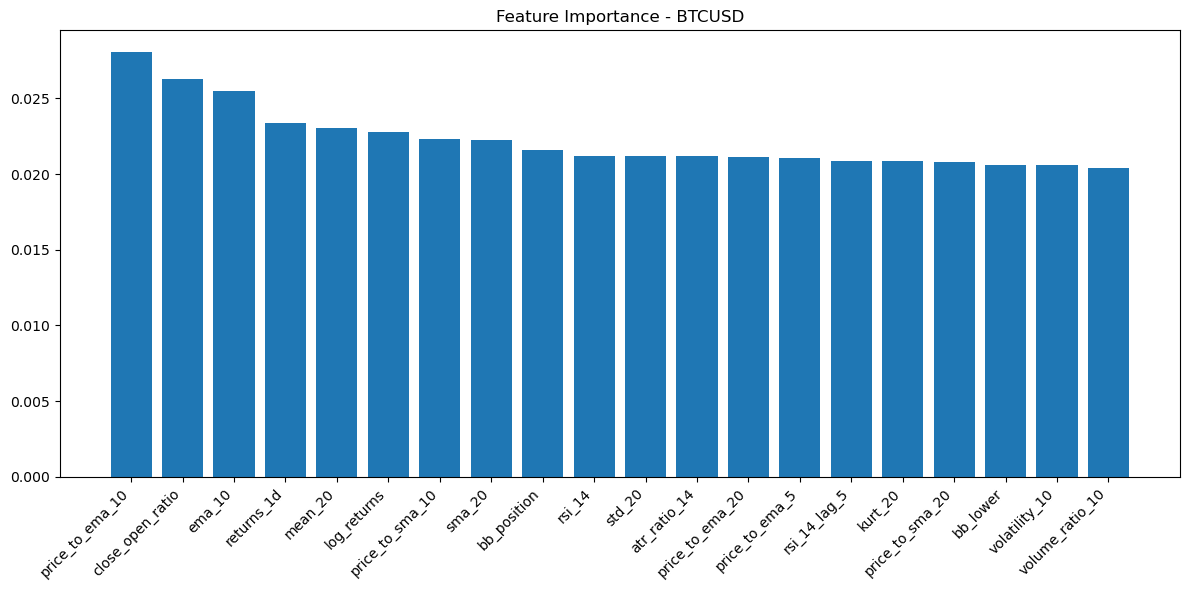


Performing walk-forward validation...
Walk-forward mean score: 0.5173 (+/- 0.0101)

Processing ETHUSD
Using existing target column
Valid samples: 10000
Train: 6000, Val: 2000, Test: 2000
Class balance - Train: 0.503, Test: 0.489

Training XGBoost...
Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.532914
Training CatBoost...
Training Random Forest...
Training Extra Trees...

Evaluating models...

XGBOOST Results:
  Accuracy: 0.5200
  Precision: 0.5060
  Recall: 0.8121
  F1: 0.6235
  ROC-AUC: 0.5353

LIGHTGBM Results:
  Accuracy: 0.5120
  Precision: 0.5010
  Recall: 0.7988
  F1: 0.6157
  ROC-AUC: 0.5160

CATBOOST Results:
  Accuracy: 0.5185
  Precision: 0.5062
  Recall: 0.6680
  F1: 0.5760
  ROC-AUC: 0.5301

RANDOM_FOREST Results:
  Accuracy: 0.5070
  Precision: 0.4979
  Recall: 0.8560
  F1: 0.6296
  ROC-AUC: 0.5181

EXTRA_TREES Results:
  Accuracy: 0.4950
  Precision: 0.4913
  Recall: 0.8927
  F1:

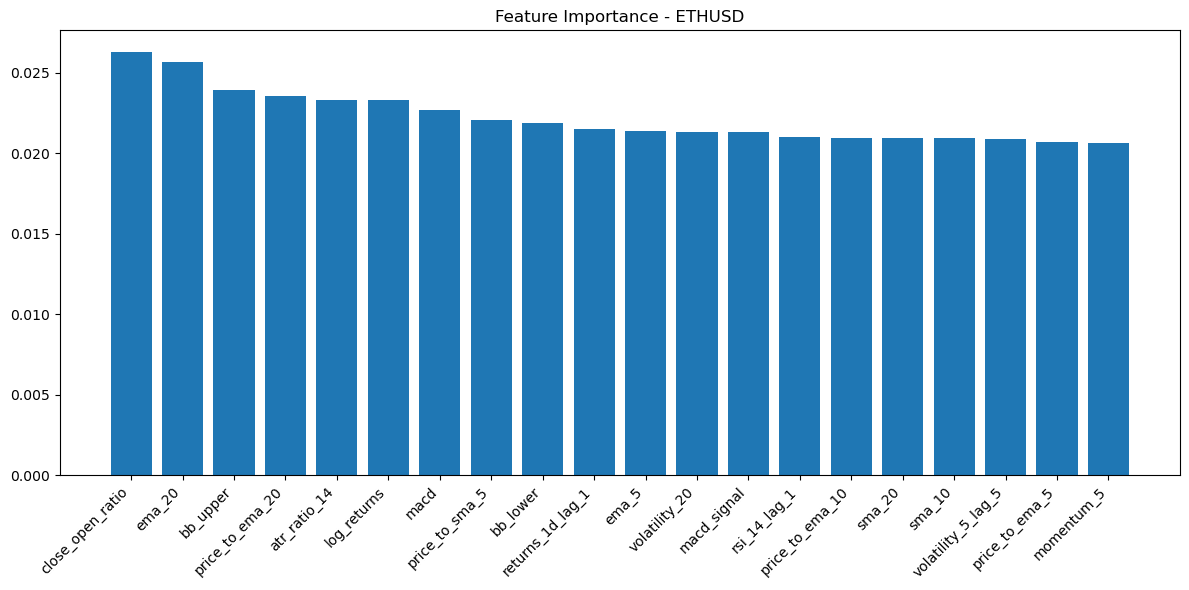


Performing walk-forward validation...
Walk-forward mean score: 0.5176 (+/- 0.0157)

Processing SOLUSD
Using existing target column
Valid samples: 10000
Train: 6000, Val: 2000, Test: 2000
Class balance - Train: 0.491, Test: 0.478

Training XGBoost...
Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's auc: 0.531254
Training CatBoost...
Training Random Forest...
Training Extra Trees...

Evaluating models...

XGBOOST Results:
  Accuracy: 0.4925
  Precision: 0.4797
  Recall: 0.7168
  F1: 0.5748
  ROC-AUC: 0.5120

LIGHTGBM Results:
  Accuracy: 0.5260
  Precision: 0.5037
  Recall: 0.6322
  F1: 0.5607
  ROC-AUC: 0.5376

CATBOOST Results:
  Accuracy: 0.5455
  Precision: 0.5359
  Recall: 0.3741
  F1: 0.4406
  ROC-AUC: 0.5440

RANDOM_FOREST Results:
  Accuracy: 0.4960
  Precision: 0.4852
  Recall: 0.8736
  F1: 0.6239
  ROC-AUC: 0.5060

EXTRA_TREES Results:
  Accuracy: 0.4980
  Precision: 0.4828
  Recall: 0.6897
  F1

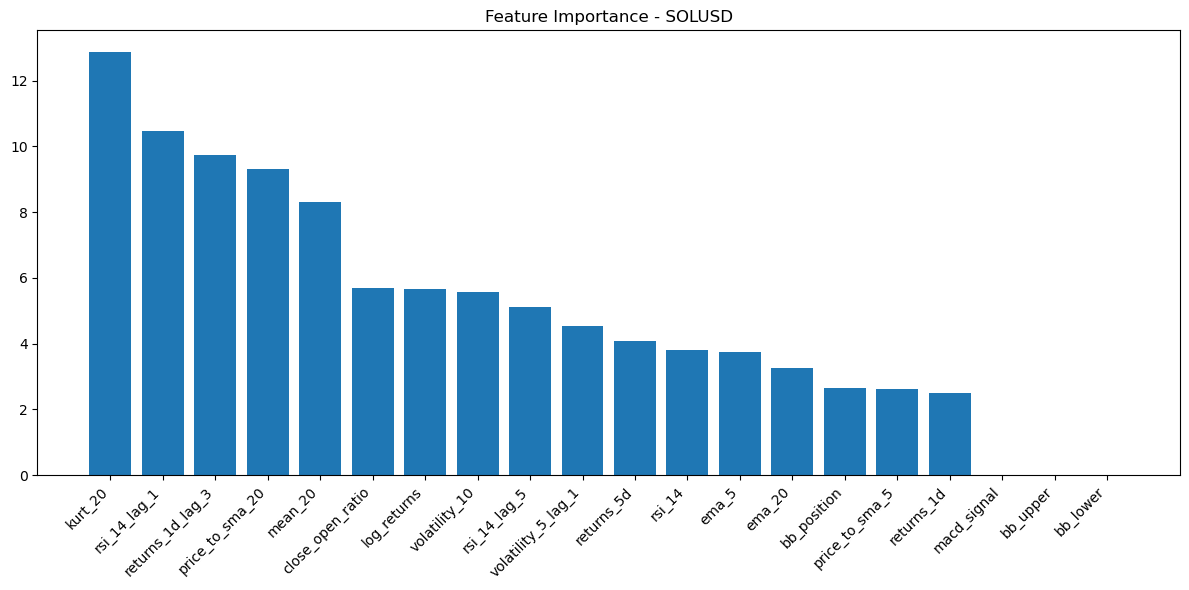


Performing walk-forward validation...
Walk-forward mean score: 0.5010 (+/- 0.0133)

Processing XRPUSD
Using existing target column
Valid samples: 10000
Train: 6000, Val: 2000, Test: 2000
Class balance - Train: 0.498, Test: 0.504

Training XGBoost...
Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.515108
Training CatBoost...
Training Random Forest...
Training Extra Trees...

Evaluating models...

XGBOOST Results:
  Accuracy: 0.4995
  Precision: 0.5027
  Recall: 0.7344
  F1: 0.5969
  ROC-AUC: 0.5037

LIGHTGBM Results:
  Accuracy: 0.5085
  Precision: 0.5103
  Recall: 0.6412
  F1: 0.5683
  ROC-AUC: 0.5018

CATBOOST Results:
  Accuracy: 0.5295
  Precision: 0.5265
  Recall: 0.6700
  F1: 0.5896
  ROC-AUC: 0.5325

RANDOM_FOREST Results:
  Accuracy: 0.4975
  Precision: 0.5012
  Recall: 0.8533
  F1: 0.6315
  ROC-AUC: 0.4948

EXTRA_TREES Results:
  Accuracy: 0.5070
  Precision: 0.5059
  Recall: 0.9762
  F1:

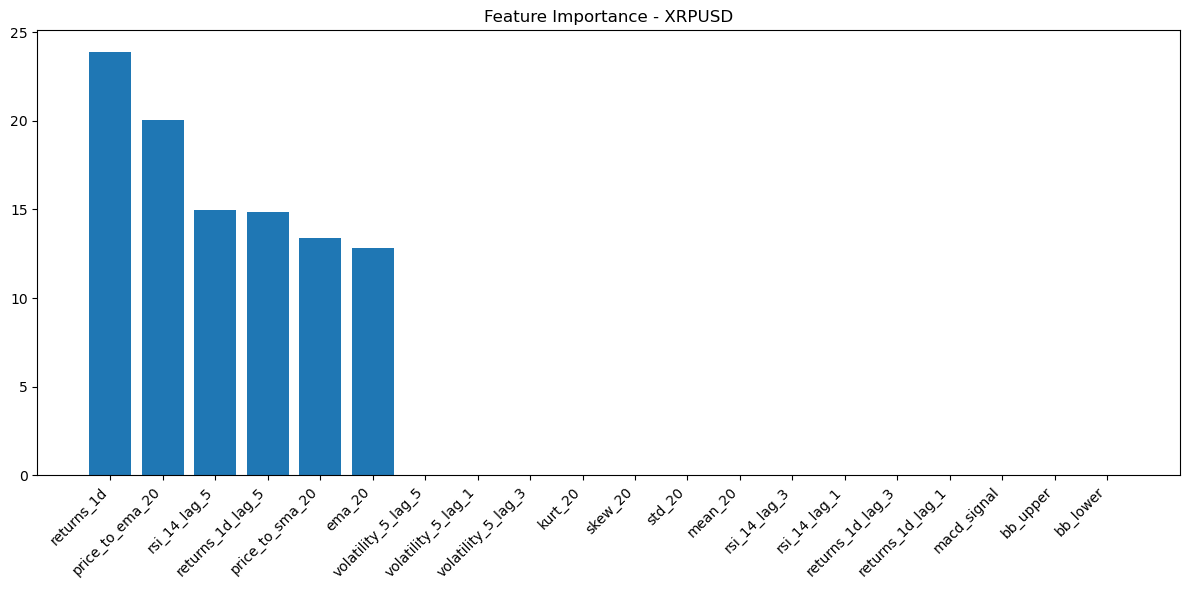


Performing walk-forward validation...
Walk-forward mean score: 0.5176 (+/- 0.0053)

Processing ADAUSD
Using existing target column
Valid samples: 10000
Train: 6000, Val: 2000, Test: 2000
Class balance - Train: 0.477, Test: 0.469

Training XGBoost...
Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	valid_0's auc: 0.516048
Training CatBoost...
Training Random Forest...
Training Extra Trees...

Evaluating models...

XGBOOST Results:
  Accuracy: 0.5100
  Precision: 0.4783
  Recall: 0.5059
  F1: 0.4917
  ROC-AUC: 0.5189

LIGHTGBM Results:
  Accuracy: 0.5325
  Precision: 0.5045
  Recall: 0.1185
  F1: 0.1919
  ROC-AUC: 0.5075

CATBOOST Results:
  Accuracy: 0.5190
  Precision: 0.4833
  Recall: 0.3853
  F1: 0.4287
  ROC-AUC: 0.5156

RANDOM_FOREST Results:
  Accuracy: 0.5095
  Precision: 0.4782
  Recall: 0.5155
  F1: 0.4961
  ROC-AUC: 0.5121

EXTRA_TREES Results:
  Accuracy: 0.5215
  Precision: 0.4895
  Recall: 0.4995
  F1:

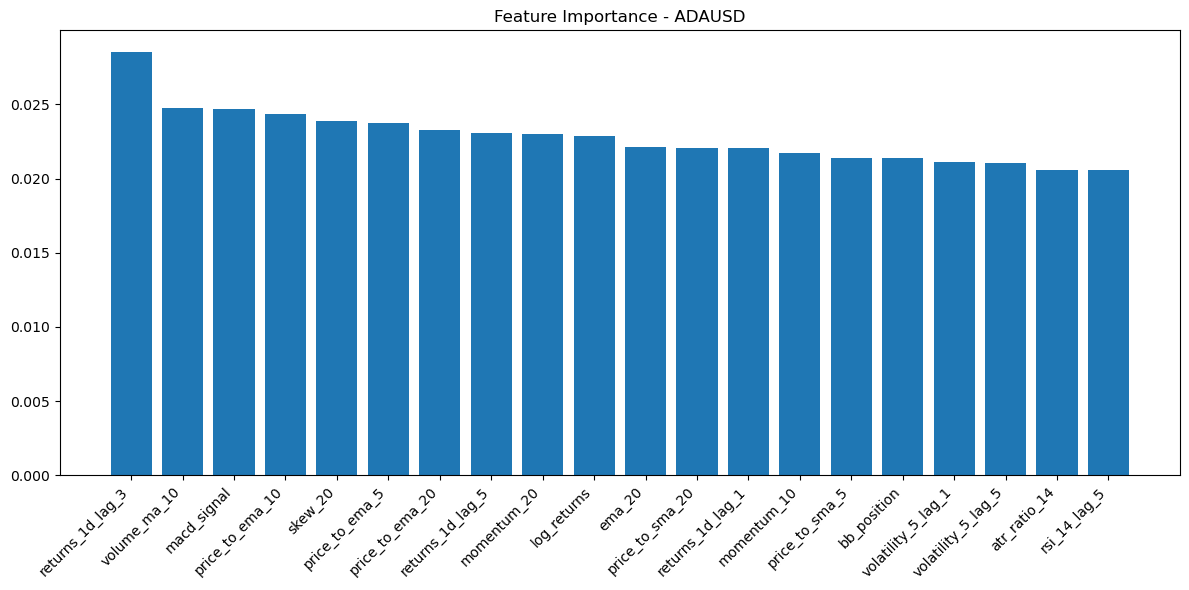


Performing walk-forward validation...
Walk-forward mean score: 0.4968 (+/- 0.0196)

Processing SPY
Using existing target column
Valid samples: 10000
Train: 6000, Val: 2000, Test: 2000
Class balance - Train: 0.467, Test: 0.480

Training XGBoost...
Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's auc: 0.549003
Training CatBoost...
Training Random Forest...
Training Extra Trees...

Evaluating models...

XGBOOST Results:
  Accuracy: 0.5185
  Precision: 0.4974
  Recall: 0.2938
  F1: 0.3694
  ROC-AUC: 0.5337

LIGHTGBM Results:
  Accuracy: 0.5265
  Precision: 0.5118
  Recall: 0.2948
  F1: 0.3741
  ROC-AUC: 0.5253

CATBOOST Results:
  Accuracy: 0.5310
  Precision: 0.5227
  Recall: 0.2635
  F1: 0.3504
  ROC-AUC: 0.5435

RANDOM_FOREST Results:
  Accuracy: 0.5200
  Precision: 0.5000
  Recall: 0.0396
  F1: 0.0734
  ROC-AUC: 0.5282

EXTRA_TREES Results:
  Accuracy: 0.5205
  Precision: 0.5029
  Recall: 0.0896
  F1: 0

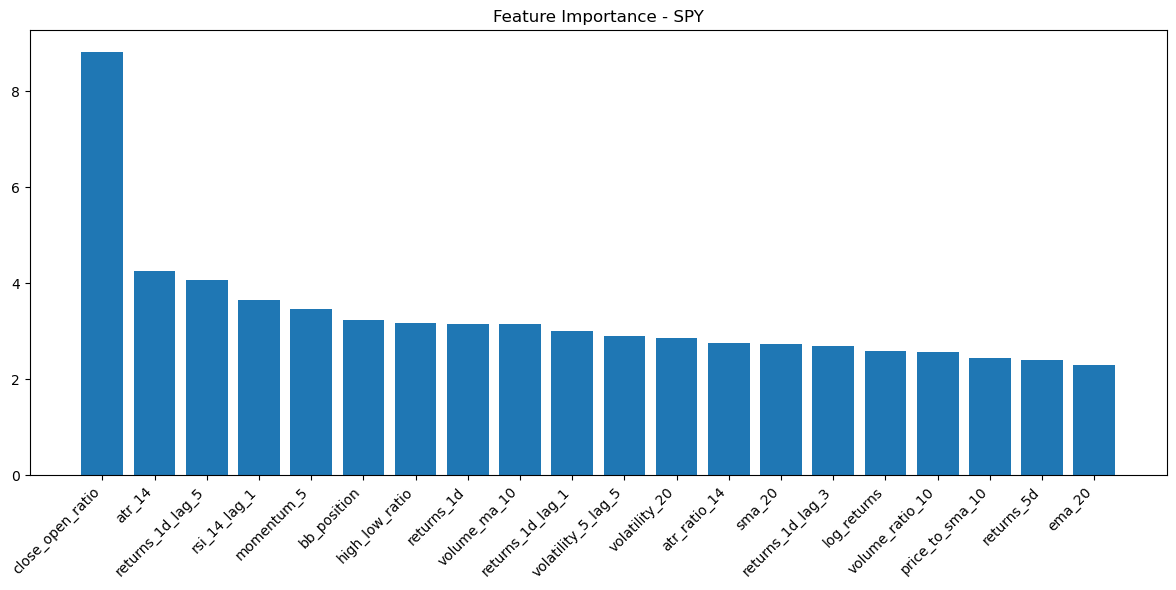


Performing walk-forward validation...
Walk-forward mean score: 0.5274 (+/- 0.0194)

Processing QQQ
Using existing target column
Valid samples: 10000
Train: 6000, Val: 2000, Test: 2000
Class balance - Train: 0.482, Test: 0.482

Training XGBoost...
Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.543818
Training CatBoost...
Training Random Forest...
Training Extra Trees...

Evaluating models...

XGBOOST Results:
  Accuracy: 0.4985
  Precision: 0.4848
  Recall: 0.6452
  F1: 0.5536
  ROC-AUC: 0.5100

LIGHTGBM Results:
  Accuracy: 0.5175
  Precision: 0.4996
  Recall: 0.6006
  F1: 0.5455
  ROC-AUC: 0.5295

CATBOOST Results:
  Accuracy: 0.5555
  Precision: 0.5460
  Recall: 0.4616
  F1: 0.5003
  ROC-AUC: 0.5645

RANDOM_FOREST Results:
  Accuracy: 0.5245
  Precision: 0.5050
  Recall: 0.6857
  F1: 0.5816
  ROC-AUC: 0.5353

EXTRA_TREES Results:
  Accuracy: 0.4855
  Precision: 0.4812
  Recall: 0.8631
  F1: 0

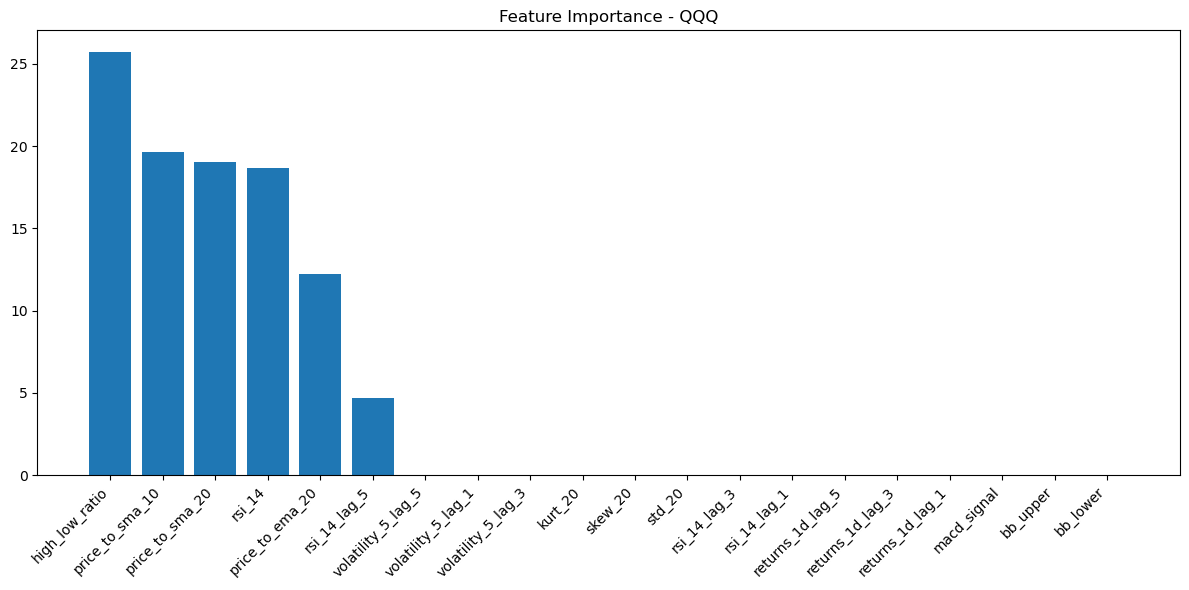


Performing walk-forward validation...
Walk-forward mean score: 0.5198 (+/- 0.0177)

Processing IWM
Using existing target column
Valid samples: 10000
Train: 6000, Val: 2000, Test: 2000
Class balance - Train: 0.467, Test: 0.473

Training XGBoost...
Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.540367
Training CatBoost...
Training Random Forest...
Training Extra Trees...

Evaluating models...

XGBOOST Results:
  Accuracy: 0.5230
  Precision: 0.4000
  Recall: 0.0169
  F1: 0.0325
  ROC-AUC: 0.4945

LIGHTGBM Results:
  Accuracy: 0.5190
  Precision: 0.3919
  Recall: 0.0307
  F1: 0.0569
  ROC-AUC: 0.5057

CATBOOST Results:
  Accuracy: 0.5060
  Precision: 0.4028
  Recall: 0.0920
  F1: 0.1497
  ROC-AUC: 0.4902

RANDOM_FOREST Results:
  Accuracy: 0.5245
  Precision: 0.4138
  Recall: 0.0127
  F1: 0.0246
  ROC-AUC: 0.4982

EXTRA_TREES Results:
  Accuracy: 0.5270
  Precision: 0.5000
  Recall: 0.0063
  F1: 0

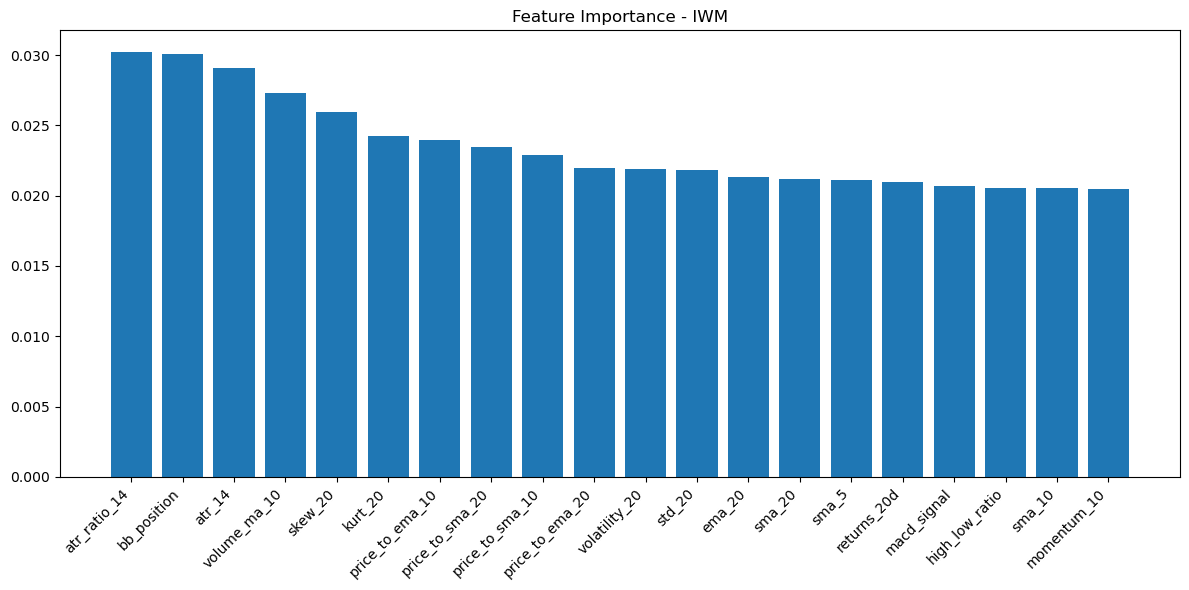


Performing walk-forward validation...
Walk-forward mean score: 0.5120 (+/- 0.0147)

Processing DIA
Using existing target column
Valid samples: 10000
Train: 6000, Val: 2000, Test: 2000
Class balance - Train: 0.487, Test: 0.487

Training XGBoost...
Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	valid_0's auc: 0.502751
Training CatBoost...
Training Random Forest...
Training Extra Trees...

Evaluating models...

XGBOOST Results:
  Accuracy: 0.5315
  Precision: 0.5265
  Recall: 0.3768
  F1: 0.4393
  ROC-AUC: 0.5358

LIGHTGBM Results:
  Accuracy: 0.5275
  Precision: 0.5335
  Recall: 0.2372
  F1: 0.3284
  ROC-AUC: 0.5327

CATBOOST Results:
  Accuracy: 0.5325
  Precision: 0.5339
  Recall: 0.3152
  F1: 0.3964
  ROC-AUC: 0.5564

RANDOM_FOREST Results:
  Accuracy: 0.5145
  Precision: 0.5030
  Recall: 0.2608
  F1: 0.3435
  ROC-AUC: 0.5200

EXTRA_TREES Results:
  Accuracy: 0.5060
  Precision: 0.4821
  Recall: 0.1940
  F1: 0.

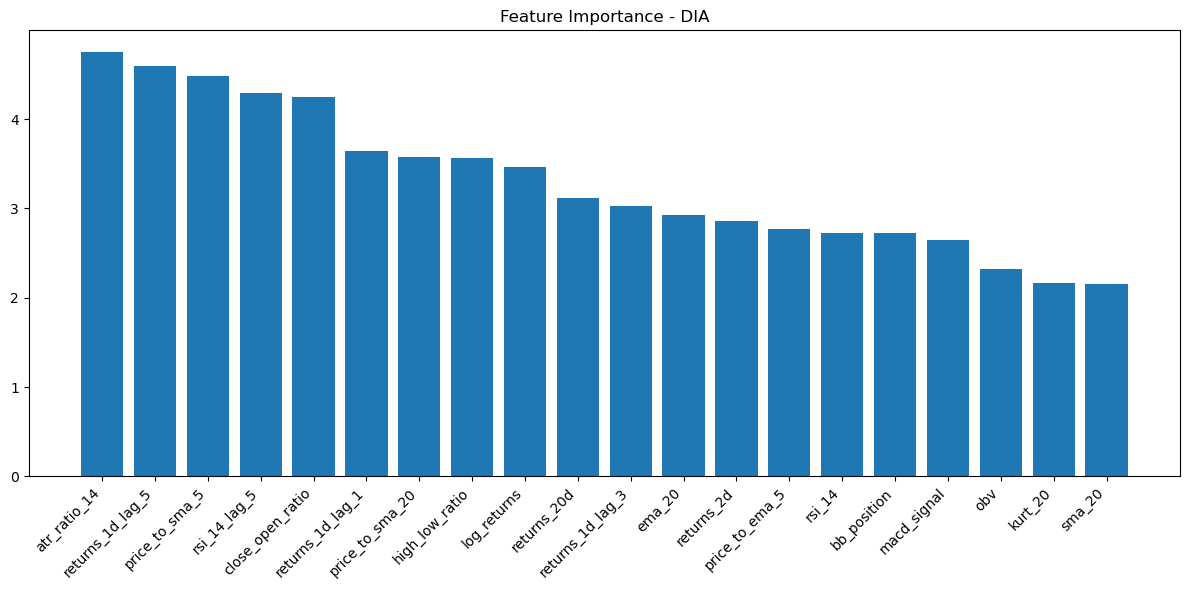


Performing walk-forward validation...
Walk-forward mean score: 0.5056 (+/- 0.0078)

Processing VTI
Using existing target column
Valid samples: 10000
Train: 6000, Val: 2000, Test: 2000
Class balance - Train: 0.499, Test: 0.517

Training XGBoost...
Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.517861
Training CatBoost...
Training Random Forest...
Training Extra Trees...

Evaluating models...

XGBOOST Results:
  Accuracy: 0.4750
  Precision: 0.3750
  Recall: 0.0232
  F1: 0.0437
  ROC-AUC: 0.4929

LIGHTGBM Results:
  Accuracy: 0.4940
  Precision: 0.5353
  Recall: 0.1615
  F1: 0.2481
  ROC-AUC: 0.5100

CATBOOST Results:
  Accuracy: 0.4930
  Precision: 0.5193
  Recall: 0.2602
  F1: 0.3466
  ROC-AUC: 0.5061

RANDOM_FOREST Results:
  Accuracy: 0.4910
  Precision: 0.5312
  Recall: 0.1315
  F1: 0.2109
  ROC-AUC: 0.5084

EXTRA_TREES Results:
  Accuracy: 0.4955
  Precision: 0.5576
  Recall: 0.1170
  F1: 0.

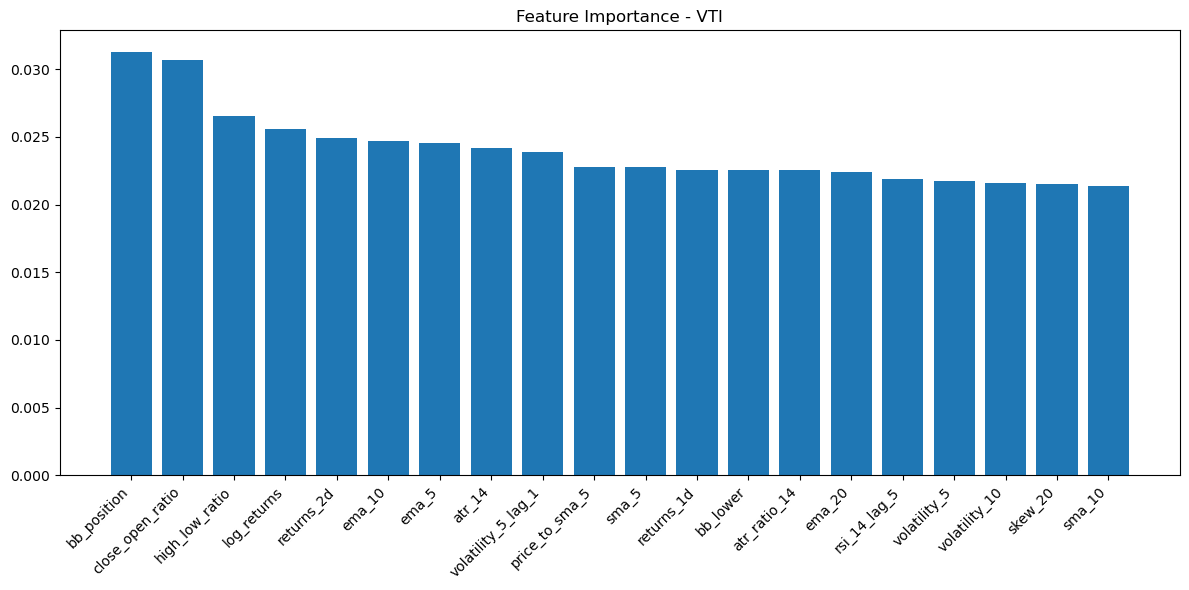


Performing walk-forward validation...
Walk-forward mean score: 0.5078 (+/- 0.0074)

CREATING FINAL VISUALIZATIONS


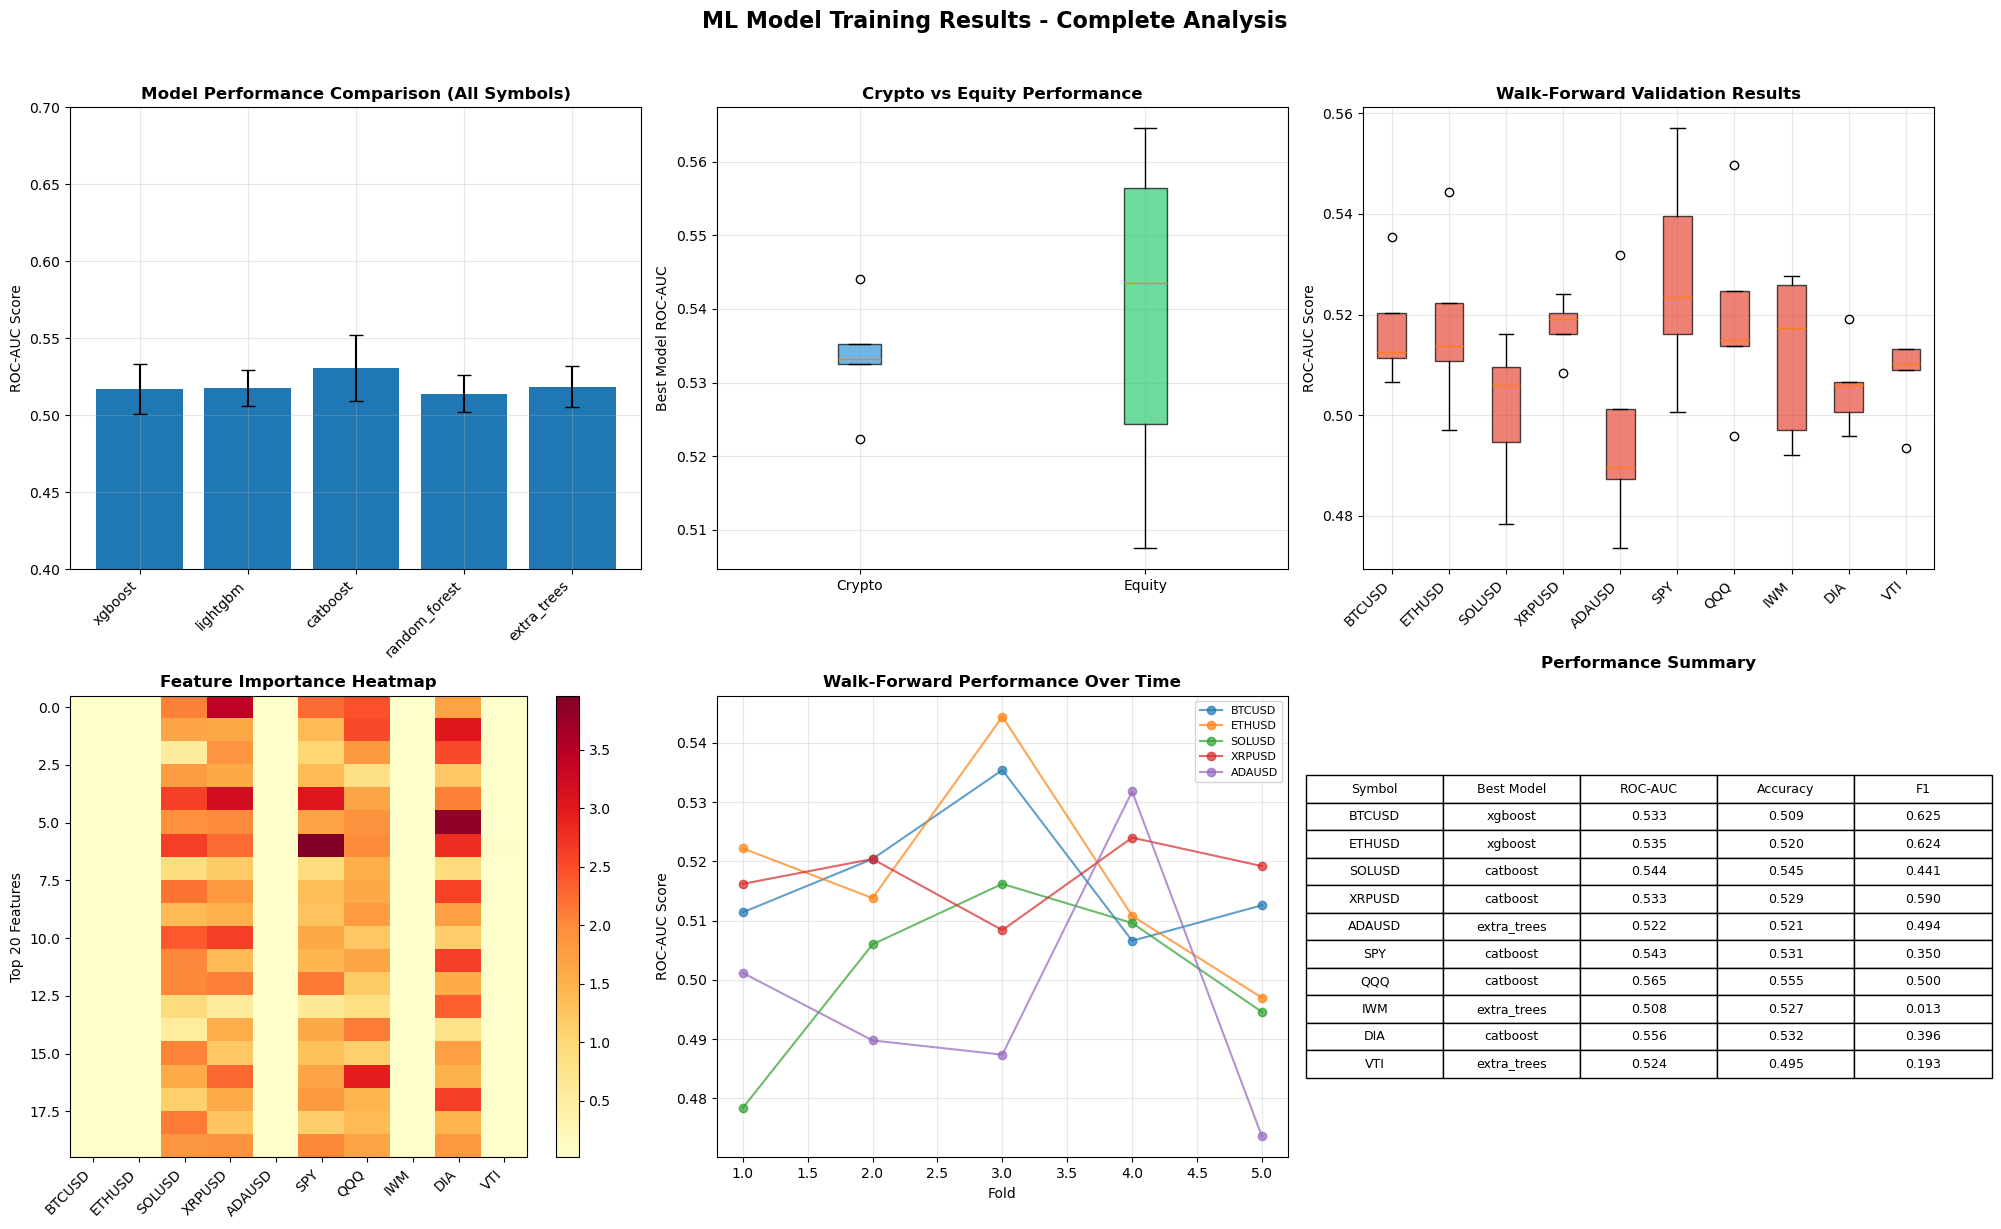

Visualization saved to notebooks\results\05_ml_models_final_visualization.png

SAVING RESULTS
Results saved to notebooks\results\05_ml_models_final.pkl
Summary saved to notebooks\results\05_ml_models_summary.csv

FINAL SUMMARY

Best Overall Model:
  Symbol: QQQ
  Model: catboost
  Type: Equity
  ROC-AUC: 0.5645

Average Performance by Model Type:
               accuracy  precision  recall      f1  roc_auc
Model                                                      
catboost         0.5242     0.5077  0.4392  0.4422   0.5307
extra_trees      0.5062     0.4990  0.5193  0.4247   0.5185
lightgbm         0.5162     0.4983  0.4218  0.4068   0.5177
random_forest    0.5090     0.4912  0.5087  0.4244   0.5140
xgboost          0.5078     0.4750  0.4960  0.4350   0.5170

Crypto vs Equity Average Performance:
        accuracy  precision  recall      f1  roc_auc
Type                                                
Crypto    0.5110     0.4982  0.6951  0.5644   0.5185
Equity    0.5143     0.4903  0.25

In [8]:
if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"\nError in main execution: {e}")
        print("\nTrying to continue with available functionality...")